In [1]:
using ModelingToolkit, DifferentialEquations, StaticArrays, Plots 
include("../../Guidance/src/Rocket_Acceleration.jl")
include("../../Guidance/src//Quaternions.jl")


(process:2412): GLib-GIO-WARNING **: 14:57:56.246: Unexpectedly, UWP app `61252GDSoftware.EasyPosterPrinter_8.0.0.0_neutral__8gw22ntmsa2nc' (AUMId `61252GDSoftware.EasyPosterPrinter_8gw22ntmsa2nc!App') supports 1 extensions but has no verbs


to_matrix (generic function with 1 method)

In [32]:
function vectdquat(vq, w)
    q = Quaternion(vq)
    dq = dquat(q, w)
    return @SVector [dq[1], dq[2], dq[3], dq[4]]
end

@variables t vq[1:4](t) ω[1:3](t)
@parameters τ[1:3]
@register vectdquat(vq, w)
D = Differential(t)

eqs = [
    collect(D.(vq)[2:4] .~ vectdquat(vq, ω)[2:4])...
    0 ~ 1 - vq[1] * vq[1] - vq[2] * vq[2] - vq[3] * vq[3] - vq[4] * vq[4]
    collect(D.(ω) .~ τ)...
]

@named att_prop = ODESystem(eqs)

prob = ODEProblem(
    structural_simplify(att_prop),
    [vq[1] => 1.0, vq[2] => 0.0, vq[3] => 0.0, vq[4] => 0.0, ω[1] => 0.0, ω[2] => 0.0, ω[3] => 0.0],
    (0.0, 100.0),
    [τ[1] => 1.0, τ[2] => 0.0, τ[3] => 0.0]
)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: 7-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0

In [33]:
sol = solve(prob)

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\rag\.julia\packages\SciMLBase\GW7GW\src\integrator_interface.jl:331


retcode: MaxIters
Interpolation: specialized 3rd order "free" stiffness-aware interpolation
t: 306-element Vector{Float64}:
 0.0
 1.0e-6
 1.1e-5
 0.00011099999999999999
 0.0011109999999999998
 0.011110999999999996
 0.11111099999999996
 0.2649152869644057
 0.4680649537068292
 0.6743841362732368
 ⋮
 6.628414765197448
 6.629737967724848
 6.630562260857018
 6.631075380343254
 6.631394363201501
 6.631592192221412
 6.631714885519363
 6.631787662569711
 6.631823146069297
u: 306-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [2.4999999999999974e-13, 0.0, 0.0, 9.999999999999991e-7, 0.0, 0.0, 1.0]
 [3.024999999999998e-11, 0.0, 0.0, 1.0999999999999991e-5, 0.0, 0.0, 1.0]
 [3.080249999999997e-9, 0.0, 0.0, 0.0001109999999999999, 0.0, 0.0, 1.0]
 [3.085802499999929e-7, 0.0, 0.0, 0.0011109999999999991, 0.0, 0.0, 0.9999999999999524]
 [3.086358024337248e-5, 0.0, 0.0, 0.011110999999999987, 0.0, 0.0, 0.9999999995237198]
 [0.0030864069537009328, 0.0, 0.0, 0.11111099999999986, 0.0, 0.

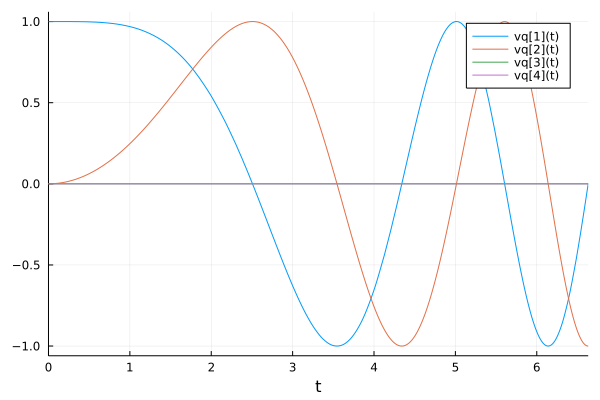

In [34]:
plot(sol, vars=vq)

In [ ]:
t_burn = 3.45
g = [0; 0; -9.80655]

Id = Diagonal([0.0826975856, 0.0826975856, 2.4778e-04])

function f!(dx, x, p, t)
    t_burn = 3.45

    r = x[1:3]
    v = x[4:6]
    quat = x[7:10]
    w = x[11:13]
    T = x[14:16]
    T_dot = x[17:19]

    Control = sample(solution.uc, t / t_burn) # if false, false

    dx[1:3] = v
    dx[4:6] = g + rotate(quat, T) * Acceleration(t)
    dx[7:10] = 1/2 * quatL(quat) * [0; w]
    dx[11:13] = Id \ ([0; 0; -0.4] × T * Thrust(t) + [0; 0; Control[4]] - cross(w, Id * w))
    dx[14:16] = T_dot
    dx[17:19] = Control[1:3]
end

prob = ODEProblem(f!, solution.xd[:, 1], (0.0, t_burn + 1.0))

condition(x,t,integrator) = x[3] # when zero halt integration
affect!(integrator) = terminate!(integrator)
cb = ContinuousCallback(condition,affect!)

sol = DifferentialEquations.solve(prob, reltol=1e-8, abstol=1e-8, callback=cb)

In [117]:
g = [0; 0; -9.80655]

Id = Diagonal([0.0826975856, 0.0826975856, 2.4778e-04])

@variables t quat[1:4](t)=[1.0, 0.0, 0.0, 0.0] ω[1:3](t)=zeros(3) qdot[1:4](t)=zeros(4) α[1:3](t)=zeros(3)
@parameters Control[1:4]=[1.0, 0.0, 0.0, 0.0]
@register_symbolic Thrust(t)
D = Differential(t)

quat = Symbolics.scalarize(quat);
ω = Symbolics.scalarize(ω);

Control = Symbolics.scalarize(Control)

eqs = [
    collect(qdot .~ 1/2 * quatL(quat) * [0; ω])...
    collect(D.(quat) .~ qdot)...
    collect(α .~ I(3) \ ([0; 0; -0.4] × Control[1:3] * Thrust(t) + [0; 0; Control[4]] - cross(ω, I(3) * ω)) )...
    collect(D.(ω) .~ α)...
]

@named Rocket = ODESystem(eqs)

prob = ODEProblem(
    structural_simplify(Rocket),
    [],
    (0.0, 10.0),
    []
)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 7-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [ ]:
using SimulationLogs

In [174]:
g = [0; 0; -9.80655]

Id = Diagonal([0.0826975856, 0.0826975856, 2.4778e-04])

@variables t
@variables quat[1:4](t)=[1.0, 0.0, 0.0, 0.0] qdot[1:4](t)=zeros(4) ω[1:3](t)=zeros(3) α[1:3](t)=zeros(3) r[1:3](t)=[0., 0., 10.] v[1:3](t)=zeros(3) a[1:3](t)=zeros(3)
@parameters Control[1:4]=[0.0, 0.0, 1.0, 0.0]
@register Thrust(t)
@register Acceleration(t)
D = Differential(t)

r = Symbolics.scalarize(r);
v = Symbolics.scalarize(v);
quat = Symbolics.scalarize(quat);
ω = Symbolics.scalarize(ω);

Control = Symbolics.scalarize(Control)

eqs = [
    collect(qdot .~ 1/2 * quatL(quat) * [0; ω])...
    collect(D.(quat) .~ qdot)...
    collect(α .~ I(3) \ ([0; 0; -0.4] × Control[1:3] * Thrust(t) + [0; 0; Control[4]] - cross(ω, I(3) * ω)) )...
    collect(D.(ω) .~ α)...
    collect(D.(r) .~ v)...
    collect(a .~ (1 - (r[3] ≤ 0) * ((g + rotate(quat, Control[1:3]) * Acceleration(t))[3] ≤ 0)) * g + rotate(quat, Control[1:3]) * Acceleration(t))...
    collect(D.(v) .~ a)
]

@named Rocket = ODESystem(eqs)

prob = ODEProblem(
    structural_simplify(Rocket),
    [],
    (0.0, 10.0),
    []
)

condition(x,t,integrator) = x[Rocket.r][3] # when zero halt integration
affect!(integrator) = terminate!(integrator)
cb = ContinuousCallback(condition,affect!)

structural_simplify(Rocket);

In [176]:
sol = solve(prob, callback=cb)
plot(sol, vars=r)

TypeError: TypeError: non-boolean (Num) used in boolean context

In [1]:
using SCPToolbox, Plots, LinearAlgebra, DifferentialEquations
include("../../Guidance/src/Quaternions.jl")


(process:9008): GLib-GIO-WARNING **: 01:09:54.536: Unexpectedly, UWP app `61252GDSoftware.EasyPosterPrinter_8.0.0.0_neutral__8gw22ntmsa2nc' (AUMId `61252GDSoftware.EasyPosterPrinter_8gw22ntmsa2nc!App') supports 1 extensions but has no verbs


to_matrix (generic function with 1 method)

In [2]:
include("Parameters.jl")
include("../../Guidance/src/Rocket_Acceleration.jl")

Reference_Diameter = 7.62e-2

NoseCone_Length = 15e-2
BodyTube_Length = 80e-2

SurfaceRoughness = 20e-6

BodyTube_CP = 0.55
NoseCone_CP = 0.1
PitchCenterX = 0
K = 1.1

InertiaTensor = Diagonal([0.0826975856, 0.0826975856, 2.4778e-04])
Burn_Time = 3.45

Rocket = RocketContsruct(Reference_Diameter, NoseCone_Length, BodyTube_Length, SurfaceRoughness, BodyTube_CP, NoseCone_CP, PitchCenterX, K, Burn_Time, InertiaTensor, Mass, Thrust, Acceleration, CG);

In [18]:
include("Atmosphere.jl")
using Geophysics

atmos = atmosphere(height -> [0; 0; -gravity(height)], Geophysics.density, sonicspeed, kinematic, randn(3)*5)

atmosphere(var"#7#8"(), UnitSystems.density, Geophysics.sonicspeed, Geophysics.kinematic, [-4.036131788410905, 8.238844115226193, 6.279221234747967])

In [19]:
module scp_new_problem
include("../../Guidance/src/6dof fixed t_burn udotdot.jl")
end # module

using .scp_new_problem

In [20]:
solution = scp_new_problem.solve(:ptr); # Remember J is augmented cost function

k  | status   | vd    | vs    | vbc   | J         | ΔJ %      | Δx    | Δu    | Δp    | δ     | dyn | ηx    | ηu    | ηp   
---+----------+-------+-------+-------+-----------+-----------+-------+-------+-------+-------+-----+-------+-------+------
1  | ALMOST_O | 1e-01 | 0e+00 | 6e-09 | 9.26e+00  |           | 8e-02 | 4e-01 | 2e-01 | 2e-01 | T   | 0.13  | 0.41  | 0.16 


2  | ALMOST_O | 5e-04 | 0e+00 | 6e-09 | 3.58e-01  | 96.14     | 1e-02 | 3e-01 | 3e-02 | 4e-02 | T   | 0.05  | 0.28  | 0.03 


3  | ALMOST_O | 3e-04 | 0e+00 | 2e-08 | 2.81e-01  | 21.36     | 5e-03 | 3e-01 | 7e-04 | 6e-03 | T   | 0.10  | 0.28  | 0.00 


4  | ALMOST_O | 8e-06 | 0e+00 | 3e-08 | 2.79e-01  | 0.99      | 2e-03 | 2e-01 | 4e-05 | 2e-03 | T   | 0.03  | 0.17  | 0.00 


5  | ALMOST_O | 4e-06 | 0e+00 | 2e-08 | 2.78e-01  | 0.09      | 1e-03 | 2e-01 | 3e-05 | 1e-03 | T   | 0.04  | 0.19  | 0.00 


3.4490538962079142


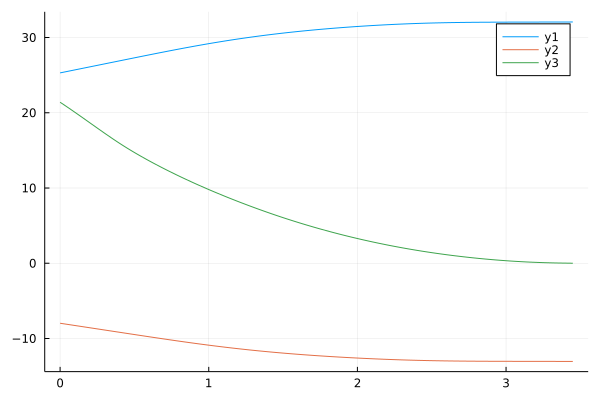

In [24]:
function f!(dx, x, p, t)
    r = x[1:3]
    height = r[3]
    v = x[4:6]
    quat = x[7:10]
    w = x[11:13]
    T = x[14:16]
    Ṫ = x[17:19]

    rocket, atmos, solution = p

    Control = sample(solution.uc, t / rocket.BurnTime) # if false, false

    dx[1:3] = v
    dx[4:6] = atmos.gravity(height) + rotate(quat, T) * rocket.Acceleration(t)
    dx[7:10] = 1/2 * quatL(quat) * [0; w]
    dx[11:13] = rocket.InertiaTensor \ ([0; 0; -0.4] × T * rocket.Thrust(t) + [0; 0; Control[4]] - cross(w, rocket.InertiaTensor * w))
    dx[14:16] = Ṫ
    dx[17:19] = Control[1:3]
end

prob = ODEProblem(f!, solution.xd[:, 1], (0.0, Rocket.BurnTime + 1.0), (Rocket, atmos, solution))

condition(x,t,integrator) = x[3] # when zero halt integration
affect!(integrator) = terminate!(integrator)
cb = ContinuousCallback(condition, nothing, affect!) # when going upwards do nothing

sol = DifferentialEquations.solve(prob, reltol=1e-8, abstol=1e-8, callback=cb)

println(sol.t[end])
Plots.plot(sol.t, reduce(hcat, sol.u)[1:3, :]')